# Filtro de partículas

	S = []  #Contem as n partículas. 

	W = [] # Pesos das partículas

	n_part = # Número de partículas

In [555]:
# -*- coding: utf-8 -*-
from random import randint, choice
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math
import random
from pf import Particle
from nav_msgs.msg import OccupancyGrid
from occupancy_field import OccupancyField
from helper_functions import angle_normalize, angle_diff


import cv2
import sys
import os
os.getcwd() 
import sys
sys.path.append(os.getcwd())

import inspercles
reload(inspercles)

# Para suprimir alguns warnings do Matplotlib Inline
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [556]:
resolution = 0.020000
origin =  [-5.000000, -5.000000, 0.000000]
occupied_thresh = 0.8
free_thresh =  0.2

inspercles.free_thresh = free_thresh # Limiar em tons de cinza para que uma celula seja considerada livre
inspercles.occupied_thresh = occupied_thresh # Limiar de celula ocupada
inspercles.origin = origin
inspercles.resolution = resolution

In [557]:
from PIL import Image as PilImage

color_image = cv2.imread("sparse_obstacles.png")
pil_image = color_image
np_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

#color_image = PilImage.open("sparse_obstacles.png", 'r')
#pil_image = color_image.convert('1') # Converte a imagem PIL para Grayscale
#np_image = np.asarray(pil_image)

particle_size = 10

#import matplotlib_render as plotmap

back_color = "black"
colors = ['red', 'green', 'cyan', 'yellow']
width, height = 775, 746

inspercles.width = width
inspercles.height = height

initial_pose = [200, 200, math.pi/8] # Posicao inicial considerada para o pf
inspercles.initial_pose = initial_pose
pose = [350, 200, math.radians(90)] # posicao "verdadeira" do robo 

inspercles.pose = pose
robot_radius=10   # Raio do robo
inspercles.robot_radius = robot_radius

# Os angulos em que o robo simulado vai ter sensores
angles = np.linspace(0.0, 2*math.pi, num=8)

particle_cloud = []

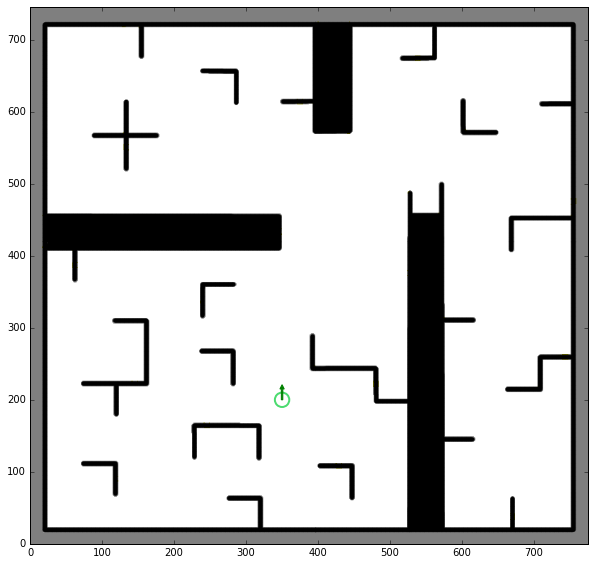

In [558]:
inspercles.nb_draw_map(color_image, pose=pose, robot=True)

#### 1. Função que gera n partículas aleatórias distribuidas uniformemente dentro de uma área minx, miny, maxx, maxy.

In [559]:
#var_theta = math.pi/3
def gerador_particulas(pose, minx, maxx, miny, maxy, var_theta, n):
    particle_cloud = []
    s = pose
    for i in range(n):
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        theta = random.uniform(s[2] - var_theta, s[2] + var_theta)
        p = Particle(x, y, theta, w=1.0) # A prob. w vai ser normalizada depois
        particle_cloud.append(p)
    return particle_cloud

In [560]:
particulas = gerador_particulas(pose, minx=250, maxx=400, miny=150, maxy=250, var_theta = math.pi/3, n=100)

In [561]:
# cheat = Particle(pose[0], pose[1], pose[2])

# particulas.append(cheat)

##### 2. Desenha as partículas geradas

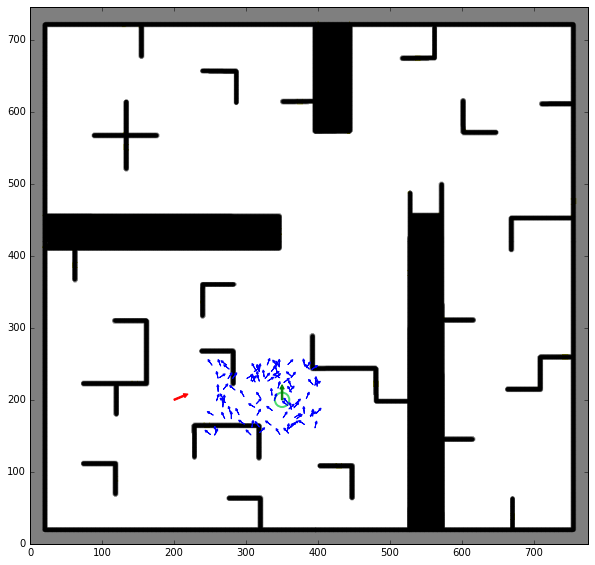

In [562]:
inspercles.nb_draw_map(color_image, particles = particulas, initial_position = initial_pose, pose=pose, robot=True)

In [563]:
angles

array([ 0.        ,  0.8975979 ,  1.7951958 ,  2.6927937 ,  3.5903916 ,
        4.48798951,  5.38558741,  6.28318531])

In [564]:
leituras, lidar_map = inspercles.nb_simulate_lidar(pose, angles, np_image)

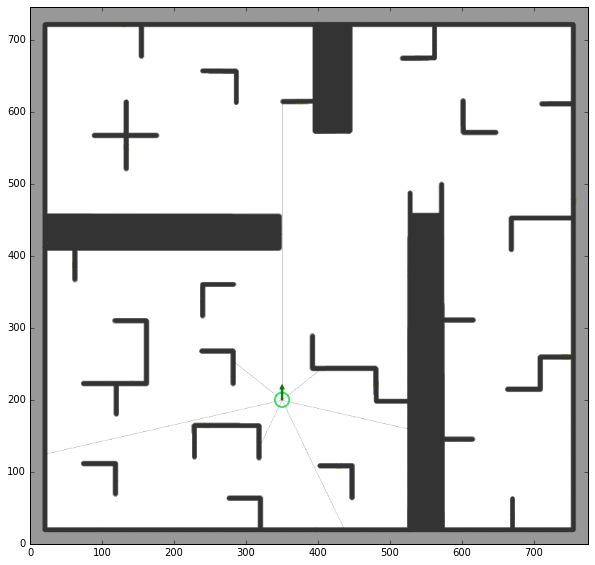

In [565]:
ax = inspercles.nb_draw_map(lidar_map, robot=True, pose=pose)
ax.imshow(color_image, alpha=0.8)
#nb_draw_map(occupancy_image)

In [566]:
#Predicao teorica das leituras
#As leituras serao retornadas pela simulacao do lidar. 
#Sao armazenadas na forma de um dicionario com: "angulo: valor da leitura"
leituras

{0.0: 410.0,
 0.89759790102565518: 82.61961026293939,
 1.7951958020513104: 334.51606837340415,
 2.6927937030769655: 65.7419196555744,
 3.5903916041026207: 196.3517252279694,
 4.4879895051282759: 177.56407294269863,
 5.3855874061539311: 64.03124237432849,
 6.2831853071795862: 410.0}

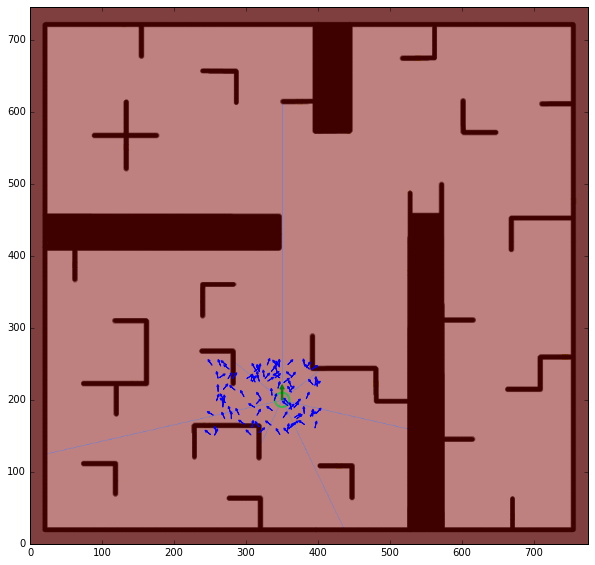

In [567]:
ax = inspercles.nb_draw_map(pil_image, pose=pose, robot=True, particles=particulas)
#ax.imshow(occupancy_image, alpha=0.2)
ax.imshow(lidar_map, alpha=0.5)

##### 4. Lista para simular os movimentos do robô.

In [568]:
movimentos = [[-10, -10, 0], [-10, 10, 0], [-10,0,0], [-10, 0, 0],
              [0,0,math.pi/12.0], [0, 0, math.pi/12.0], [0, 0, math.pi/12],[0,0,-math.pi/4],
              [-5, 0, 0],[-5,0,0], [-5,0,0], [-10,0,0],[-10,0,0], [-10,0,0],[-10,0,0],[-10,0,0],[-15,0,0],
              [0,0,-math.pi/4],[0, 10, 0], [0,10,0], [0, 10, 0], [0,10,0], [0,0,math.pi/8], [0,10,0], [0,10,0], 
              [0,10,0], [0,10,0], [0,10,0],[0,10,0],
              [0,0,-math.radians(90)],
              [math.cos(math.pi/3)*10, math.sin(math.pi/3),0],[math.cos(math.pi/3)*10, math.sin(math.pi/3),0],[math.cos(math.pi/3)*10, math.sin(math.pi/3),0],
              [math.cos(math.pi/3)*10, math.sin(math.pi/3),0]]

##### 5. Função que aplica um deslocamento [delta_x, delta_y, delta_theta] com um desvio padrão [std_x, std_y, std_theta] a todas as partículas

In [569]:
from random import gauss

def deslocamento(particulas, delta, std):
    for i in particulas:
        xnew = delta[0] + gauss(0, std[0])
        ynew = delta[1] + gauss(0, std[1])
        tnew = delta[2] + gauss(0, std[2])
        i.x = i.x + xnew
        i.y = i.y + ynew
        i.theta = i.theta + tnew
    return particulas

##### 6. Partículas após o deslocamento

In [570]:
# inspercles.nb_draw_map(color_image, particles = deslocamento(particulas,[2,3,4],[5,3,2]), initial_position = initial_pose, pose=pose, robot=True)
# lidar_map = np.copy(np_image)
# retorno_lidar_robo = np.copy(lidar_map)

##### 7. Cálculo de $P(D|H)$
$$P(z_t | x_t) = \alpha \prod_{j}^M{e^{\frac{-(z_j - \hat{z_j})}{2\sigma^2}}}$$


##### 8. Usando os resultados de $P(D|H)$, $P(H|D)$ é calculado e inserido numa lista de probabilidades das partículas

In [571]:
#Zt: posicao leituras
#Xt: vetor [z,y,teta]

#alfa: constate de normalizacao
#zj_chapeu = nb_simulate_lidar()
#zj = leituras
#norm.pdf(zj, loc=zj_chapeu, scale = scn)

retorno_lidar_robo = np.copy(lidar_map)
retorno_lidar_particulas = np.copy(lidar_map)

produtos =[]
sigma = 5

# Simula a leitura do lidar
z_real, lidar_map = inspercles.nb_simulate_lidar_fast(pose, angles, np_image, retorno = retorno_lidar_robo)

for i in particulas:
    #zj_chapeu = inspercles.nb_simulate_lidar([i.x,i.y,i.theta], angles, np_image)[0]
    zj_chapeu, imagem = inspercles.nb_simulate_lidar_fast([i.x,i.y,i.theta], angles, np_image, retorno = retorno_lidar_particulas, output_image = False)
    P2 = 1 

    for key,value in z_real.iteritems():
        value_chapeu=zj_chapeu[key]
        P1 = math.e**((-(value-value_chapeu))/50)
        P2 *= P1
    produtos.append(P2)
    
#P*alfa = 1
soma = sum(produtos)
alpha = 1/soma

lista_final = []
for j in produtos:
    j *= alpha
    lista_final.append(j)

print("P(D|H):",produtos)   
print("P(H|D):",lista_final)
print("Alfa:", alpha)
print(sum(lista_final))
print(max(lista_final))

('P(D|H):', [9.0219109726405597e-07, 0.0003300122278241187, 2.835511083069908e-06, 6.545523149712563e-05, 1.0186524472966088e-05, 3.8604166023661702e-10, 0.0051060395976278697, 1.352069477136042e-06, 9.0301459720226366e-05, 0.013345983146057842, 5.0591210850195723e-15, 7.6688391498669998e-06, 5.6974738675602731e-08, 4.13177586229117e-06, 5.9494608223147956e-08, 0.0031839003961986194, 2.7641018166709031e-13, 6.4900921758281619e-05, 7.3463062427616498e-07, 33.461782042510059, 3.240104050410231e-06, 1.505418956458972e-05, 1.7577286858604599e-10, 0.00017566980101781814, 2.2895712278336726e-09, 0.023729989706795809, 8.0550311258234423e-06, 3.5549105920027135e-11, 1.1977651719541301e-07, 0.00054748118128411245, 0.60931286342461144, 1.2473810265435089e-07, 6.9077413539917684e-06, 2.0637147470858903e-13, 0.0001317459452926701, 2.8179729185762389e-07, 2.7713958218153672e-08, 337.12167815178782, 6.1039556965407165e-08, 2.2180700922864218e-05, 2.435256287942245, 1.1152940326035263e-06, 1.17405069

##### 9. Reamostre as partículas de forma proporcional à probabilidade

In [572]:
plt.ioff() # Desliga o modo interativo, para nao aparecerem muitas imagens no meio

frames = 1
delta = [2,3,4]
std = [3,3,0.2]

for delta in movimentos:
    for i in range(len(pose)):
        pose[i]+=delta[i]
    
    #Deslocamento
    for i in particulas:
        xnew = delta[0] + gauss(0, std[0])
        ynew = delta[1] + gauss(0, std[1])
        tnew = delta[2] + gauss(0, std[2])
        i.x = i.x + xnew
        i.y = i.y + ynew
        i.theta = i.theta + tnew
    
    produtos =[]
    #sigma = 5

    # Simula a leitura do lidar
    z_real, lidar_map = inspercles.nb_simulate_lidar_fast(pose, angles, np_image, retorno = retorno_lidar_robo)

    for i in particulas:
        #zj_chapeu = inspercles.nb_simulate_lidar([i.x,i.y,i.theta], angles, np_image)[0]
        zj_chapeu, imagem = inspercles.nb_simulate_lidar_fast([i.x,i.y,i.theta], angles, np_image, retorno = retorno_lidar_particulas, output_image = False)
        P2 = 1 

        for key,value in z_real.iteritems():
            value_chapeu=zj_chapeu[key]
            P1 = math.e**((-(value-value_chapeu))/50)
            P2 *= P1
        produtos.append(P2)

    #P*alfa = 1
    soma = sum(produtos)
    alpha = 1/soma

    lista_final = []
    for j in produtos:
        j *= alpha
        lista_final.append(j)
        
    novas_particles = Particle.draw_random_sample(particulas, lista_final, 25)
    
    #Aplicar desvio padrao nas novas particulas (x, y, theta)
    for i in novas_particles:
        desv_x = np.random.normal(0, 1)
        desv_y = np.random.normal(0, 1)
        desv_theta = np.random.normal(0, 1)
        
        i.x = i.x + desv_x
        i.y = i.y + desv_y
        i.theta = i.theta + desv_theta
        
    

    # Simula a leitura do lidar
    leituras, lidar_map = inspercles.nb_simulate_lidar_fast(pose, angles, np_image)
    
    # Desenha as particulas
    ax = inspercles.nb_draw_map(color_image, pose=pose, robot=True, particles=particulas)
    
    
    #ax.imshow(occupancy_image, alph.2)
    # Desenha o mapa do lidar
    ax.imshow(lidar_map, alpha=0.5)
    
    particulas = novas_particles
    
    plt.savefig("anim%04d.png"%frames, bounds="tight")
    
    frames+=1
    plt.close('all')


plt.ion()

In [573]:
!convert -delay 10 -loop 1 anim*png tentativa.gif

<img src="tentativa.gif">